# CDK Binding Affinity

In [226]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns


### Columns

- `BindingDB Ligand Name`: (Text) name of ligand. 

- `Target Name`: (Text) Name of the target (indicate deletions (e.g., a truncated sequence) or mutations (e.g., Met results changed for the sake of stability)). For example, [262-930, L692P] means the protein includes residues 262-930 of the full sequence and Leu 692 is replaced by Pro. 

- `Target Source Organism According to Curator or DataSource`: (Text) Organism associated with the protein target. 



##### Measure of Binding Affinity:

- `Ki (nM)`: (Real>0) Inhibition Constant; concentration of the inhibitor required to reduce the activity of an enzyme by half in the absence of the substrate. The lower the Ki value, the stronger the inhibitor binds to its target.

- `IC50 (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document) The concentration of the inhibitor that reduces the enzyme activity by 50%. Same as Ki but corrected for experimental condition, making it more accurate and independent of substrate concentration.

- `Kd (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document.) Dissociation Constant; It represents the concentration of the ligand at which half of the available binding sites on the target are occupied. Lower Kd, higher binding affinity.

- `EC50 (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document.) Concentration of a drug or ligand required to produce 50% of its maximum effect.

- `kon (M-1-s-1)`: (Real >0) Assocition rate constant; Measure of the rate at which a ligand binds to its target, how quickly the ligand and the target come together to form a complex.

- `Koff(s-1)`

- `pH`

- `Temp ( C)`



##### Chain of the Binding: 

- `Number of Protein Chains in Target (>1 implies a multichain complex)`: (1,2 or 3) The following information will be provided, if available, for each chain in the protein. (indicated by .n for the n+1 chain)

- `BindingDB Target Chain Sequence`:(text) sequences of AAs. 

- `UniProt (SwissProt) Entry Name of Target Chain`: (text) name of the target chain.

Or: 

- `UniProt (TrEMBL) Entry Name of Target Chain`: (text) name of the target chain. 




In [227]:
df = pd.read_csv('data/BindingDB_col_cleaned.tsv', sep='\t') # loading of the cleaned data (CDKs selected and columns necessary for analysis selected)
df.head()

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,BindingDB Target Chain Sequence.1,UniProt (SwissProt) Entry Name of Target Chain.1,UniProt (TrEMBL) Entry Name of Target Chain.1,BindingDB Target Chain Sequence.2,UniProt (SwissProt) Entry Name of Target Chain.2,UniProt (TrEMBL) Entry Name of Target Chain.2
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,5800,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,>1000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
2,COc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Methoxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,4300,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
3,Oc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,3000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
4,CC(C)(C)OC(=O)Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl...,3-((4-(N-BOC-amino)phenyl)amino)-4-((3-chlorop...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,57000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN


### Formating values of Binding Affinity constant 

The values for Ki, Kd, IC50... can take forms like >100 or 2e+5 that need to be transformed to be analysed

In [228]:
# Fonction 'clean' to remove the characters > and <, remove the spaces and convert the strings into integers
def clean(ki, patern=['<', '>']):
    ki = str(ki).replace(patern[0], '')
    ki = str(ki).replace(patern[1], '')
    ki = ki.strip()       
    try:
        ki = int(ki)
    except ValueError:  
        ki = None
    return (ki)

### Binding Affinity constant ditribution 
- Ki (nM):

In [229]:
Ki_cleaned = df['Ki (nM)'].apply(lambda ki: clean(ki)) # cleaning of the Ki values
Ki_cleaned = Ki_cleaned.dropna(axis=0) # deleting all the NaN values

In [230]:
Ki_cleaned.describe()

count     1560.000000
mean      2778.834615
std       5640.131485
min          1.000000
25%         69.750000
50%        300.000000
75%       1357.500000
max      20000.000000
Name: Ki (nM), dtype: float64

Discuss: 50% of the values are <300. A Ki<300 represents a strong or moderate affinity. There is outliers (Ki equal to 20000) that represents no binding affinity. 

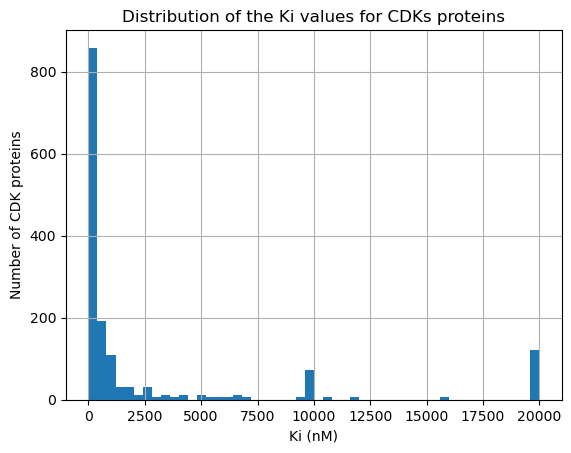

In [231]:
plt.title('Distribution of the Ki values for CDKs proteins')
plt.xlabel('Ki (nM)')
plt.ylabel('Number of CDK proteins')
Ki_cleaned.hist(bins=50)
plt.show()

- IC50 (nM):

In [232]:
# 45'822 rows have IC50 value, 6822 of them contain < and 13476 contain >
# we should do samples to put the values into ranges => not done yet because maybe not useful... instead the same technique as above is performed

IC50_cleaned = df['IC50 (nM)'].apply(lambda ic: clean(ic))
IC50_cleaned[IC50_cleaned > 20000] = np.nan # some very high values make the distribution not readable and relevant so we decided to remove them
IC50_cleaned = IC50_cleaned.dropna(axis=0)


In [233]:
IC50_cleaned.describe()

count    37512.000000
mean      2846.408989
std       5218.814603
min          1.000000
25%         36.000000
50%        264.500000
75%       2500.000000
max      20000.000000
Name: IC50 (nM), dtype: float64

discuss: same idea, almost the same value of the 50th percentile.

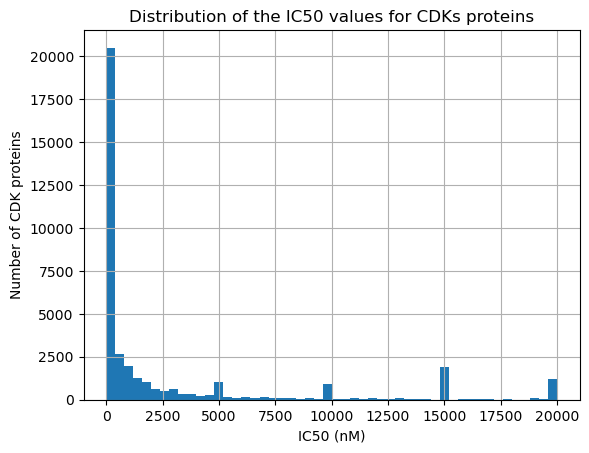

In [234]:
plt.title('Distribution of the IC50 values for CDKs proteins')
plt.xlabel('IC50 (nM)')
plt.ylabel('Number of CDK proteins')
IC50_cleaned.hist(bins=50)
plt.show()

- Kd (nM):

In [235]:
# 3552 rows have Kd value and 2058 Kd are equal to >100000 
Kd_cleaned = df['Kd (nM)'].apply(lambda kd: clean(kd))
Kd_cleaned = Kd_cleaned.dropna(axis=0)

In [236]:
Kd_cleaned.describe()

count      3066.000000
mean      68256.953033
std       45653.357450
min           8.000000
25%        2300.000000
50%      100000.000000
75%      100000.000000
max      100000.000000
Name: Kd (nM), dtype: float64

Discuss: More than 50% of the values is equal to 100000 (very weak binding affinity).

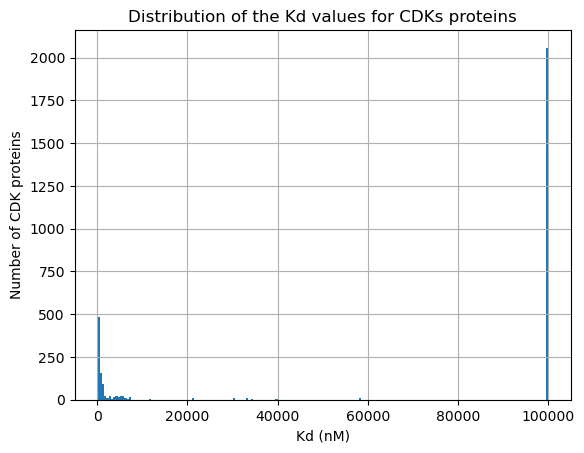

In [237]:
plt.title('Distribution of the Kd values for CDKs proteins')
plt.xlabel('Kd (nM)')
plt.ylabel('Number of CDK proteins')
Kd_cleaned.hist(bins=200)
plt.show()

- EC50 (nM):

In [238]:
EC50_cleaned = df['EC50 (nM)'].dropna()
print(EC50_cleaned)

4548     70.0
13297    70.0
22046    70.0
30795    70.0
39544    70.0
48293    70.0
Name: EC50 (nM), dtype: float64


Discuss: There is only 6 values of EC50, all equals to 70. It is probabybly not exploitable.

- Number of target chains:

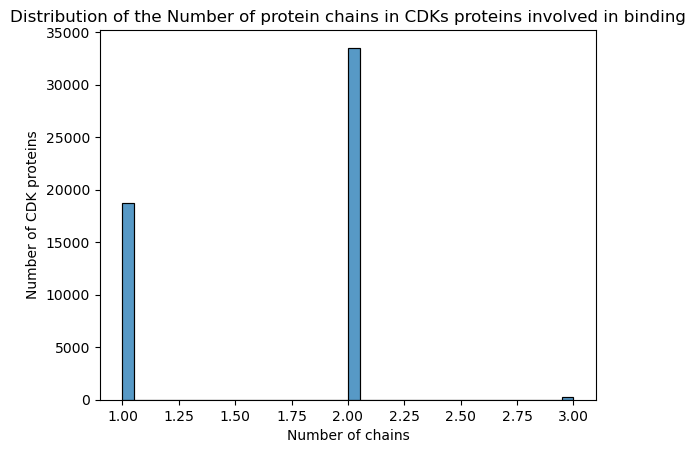

In [239]:
Number_of_chain_cleaned=df['Number of Protein Chains in Target (>1 implies a multichain complex)'].dropna()
plt.title('Distribution of the Number of protein chains in CDKs proteins involved in binding')
plt.xlabel('Number of chains')
plt.ylabel('Number of CDK proteins')
sns.histplot(Number_of_chain_cleaned)
plt.show()


How to achieve this (in steps):
Preprocess:
only looking at relevant (47) CDK and their binding ligands (suppose it will be enough data? we can add more data for milestone 3)

Find all unique binding ligands (4500?)

Create four dataframes for each of the measures of binding affinities for CDKs and ligands (will each be of dimension 47x4500?).

Assign labels to the affinity scores for three levels of affinity (Ki_weak, Ki_moderate, Ki_strong, EC50_weak, EC_moderate , ... etc. 12 labels in total) Julie and Mathilde might find a good source to indicate this. We will have to define a good (and fair!) mapping and justify it!
Construct dataframe: match unique pairs ligands-CDKs -> make dataframe with the affinity measures and labels as rows

Maybe dimensionality reduction: PCA (but we dont have so many parameters so might not make sense)

Clustering/grouping: group on similar ligands (from a bioperspective view - how to? database?)

Look into the Regression model if time permits.


In [240]:
df.shape

(52494, 22)

In [241]:
#df consists only of CDK's and their binding ligands
#Preprocessing to only consider CDK's and their binding ligands
#Number of unique CDK's
df["Target Name"].unique().size

47

In [242]:
df["BindingDB Ligand Name"].unique().size

4577

In [243]:
# Checking how many different ligands are there for each CDK
df.groupby("Target Name")["BindingDB Ligand Name"].nunique().sort_values(ascending=False)

Target Name
Cyclin-dependent kinase 2/G1/S-specific cyclin-E1                                1156
Cyclin-A2/Cyclin-dependent kinase 2                                               870
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1                                 821
Cyclin-dependent kinase 4                                                         706
Cyclin-dependent kinase/G2/mitotic-specific cyclin- 1                             509
Cyclin-dependent kinase 1                                                         468
Cyclin-dependent kinase 2                                                         456
Cyclin-dependent kinase 9                                                         455
Cyclin-dependent kinase 1/G2/mitotic-specific cyclin-B                            451
Cyclin-T1/Cyclin-dependent kinase 9                                               337
Cyclin-dependent kinase 6                                                         269
Cyclin-dependent kinase 5 activator 1 [99-

In [244]:
# Cleaning columns of binding affinity scores 

affinity_columns = ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']
for col in affinity_columns:
    df[col] = df[col].apply(lambda value: clean(value))

df.sample(5)

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,BindingDB Target Chain Sequence.1,UniProt (SwissProt) Entry Name of Target Chain.1,UniProt (TrEMBL) Entry Name of Target Chain.1,BindingDB Target Chain Sequence.2,UniProt (SwissProt) Entry Name of Target Chain.2,UniProt (TrEMBL) Entry Name of Target Chain.2
12641,CN1CCN(CC1)c1ccc(Nc2ncc(C(=O)c3cccc(c3)C(F)(F)...,"2,4-Diamino-5-ketopyrimidine 19::2-N-[4-(4-met...",Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,10000.0,NaN,NaN,None,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
41821,COc1ccc(F)cc1-c1c(F)cnc2[nH]c(cc12)C1=CC2CN(CC...,"US9073922, 287::US9796708, Example 287",Cyclin-dependent kinase 9,Homo sapiens,NaN,104.0,NaN,None,NaN,NaN,...,1,MAKQYDSVECPFCDEVSKYEKLAKIGQGTFGEVFKARHRKTGQKVA...,CDK9_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2795,CC(C)n1cnc2c(Cl)nc(I)nc12,"2,6,9-Trisubstituted purine deriv. 4b::6-Chlor...",Cyclin-dependent kinase 1/G2/mitotic-specific ...,Marthasterias glacialis,NaN,150000.0,NaN,None,NaN,NaN,...,2,MEDYVKIEKIGEGTYGVVYKGRHKSTGQVVAMKKIRLESEEEGVPS...,CDK1_ORYLA,NaN,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,CCNB_MARGL,NaN,NaN,NaN,NaN
5734,C1CCC(C1)n1c2ccccc2c2cnc(Nc3ccc(cc3)N3CCNCC3)nc12,"US8841312, 47",Cyclin-dependent kinase 6,Homo sapiens,NaN,NaN,NaN,None,NaN,NaN,...,1,MEKDGLCRADQQYECVAEIGEGAYGKVFKARDLKNGGRFVALKRVR...,CDK6_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22454,COc1ccc(F)cc1-c1ccnc2[nH]c(cc12)C1CCNCC1S(C)(=...,"US9073922, 230",Cyclin-dependent kinase 9,Homo sapiens,NaN,22.0,NaN,None,NaN,NaN,...,1,MAKQYDSVECPFCDEVSKYEKLAKIGQGTFGEVFKARHRKTGQKVA...,CDK9_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [245]:
# Constructing 4 dataframes for each type of affinity score

Ki_df = df[
    [
        "Ligand SMILES",
        "BindingDB Ligand Name",
        "Target Name",
        "Target Source Organism According to Curator or DataSource",
        "Ki (nM)",
        "BindingDB Target Chain Sequence",
    ]
]
Kd_df = df[
    [
        "Ligand SMILES",
        "BindingDB Ligand Name",
        "Target Name",
        "Target Source Organism According to Curator or DataSource",
        "Kd (nM)",
        "BindingDB Target Chain Sequence",
    ]
]
IC50_df = df[
    [
        "Ligand SMILES",
        "BindingDB Ligand Name",
        "Target Name",
        "Target Source Organism According to Curator or DataSource",
        "IC50 (nM)",
        "BindingDB Target Chain Sequence",
        "UniProt (SwissProt) Entry Name of Target Chain"
    ]
]
EC50_df = df[
    [
        "Ligand SMILES",
        "BindingDB Ligand Name",
        "Target Name",
        "Target Source Organism According to Curator or DataSource",
        "EC50 (nM)",
        "BindingDB Target Chain Sequence",
    ]
]

In [246]:
# For each newly constructed df we will drop rows with NaN values in the affinity score column
Ki_df = Ki_df.dropna(subset=["Ki (nM)"])
Kd_df = Kd_df.dropna(subset=["Kd (nM)"])
IC50_df = IC50_df.dropna(subset=["IC50 (nM)"])
EC50_df = EC50_df.dropna(subset=["EC50 (nM)"])

# Checking the number of rows in each df
print(Ki_df.shape)
print(Kd_df.shape)
print(IC50_df.shape)
print(EC50_df.shape)

(1560, 6)
(3066, 6)
(40704, 7)
(0, 6)


In [247]:
IC50_df.head()

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,5800.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,1000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN
2,COc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Methoxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,4300.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN
3,Oc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,3000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN
4,CC(C)(C)OC(=O)Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl...,3-((4-(N-BOC-amino)phenyl)amino)-4-((3-chlorop...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,57000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN


In [248]:
print(IC50_df["IC50 (nM)"].describe())

count      40704.000000
mean       12340.050118
std        59544.045676
min            1.000000
25%           43.000000
50%          400.000000
75%         5000.000000
max      1000000.000000
Name: IC50 (nM), dtype: float64


In [249]:
# If there are duplicates of CDK-ligand pair we take the median of the affinity score & the target source organism is the same

IC50_df = IC50_df.groupby(["BindingDB Ligand Name", "Target Name", "Target Source Organism According to Curator or DataSource", "BindingDB Target Chain Sequence", "UniProt (SwissProt) Entry Name of Target Chain"])["IC50 (nM)"].median().reset_index()

In [250]:
IC50_df.sample(10)

,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM)
1999,"4-({2-amino-6-[(2,6-dichlorophenyl)carbonyl]im...",Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,1144.0
3024,8-Cyclopentyl-6-hydroxymethyl-2-(5-piperazin-1...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,5000.0
727,"2,6-Diamino-4-cyclohexylmethoxy-5-nitrosopyrim...",Cyclin-A2 [171-432]/Cyclin-dependent kinase 2,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,2200.0
5516,"US9499492, 36",Cyclin-T1/Cyclin-dependent kinase 9,Homo sapiens,MEGERKNNNKRWYFTREQLENSPSRRFGVDPDKELSYRQQAANLLQ...,CCNT1_HUMAN,91.5
783,2-(2-hydroxyethylpiperidyl)-9-isopropylpurine ...,Cyclin-dependent kinase 1,Homo sapiens,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,1400.0
861,2-Amino-6-(2-cyclohexyl)ethoxypurine::6-(2-cyc...,Cyclin-dependent kinase 1/G2/mitotic-specific ...,Marthasterias glacialis,MEDYVKIEKIGEGTYGVVYKGRHKSTGQVVAMKKIRLESEEEGVPS...,CDK1_ORYLA,37000.0
5206,"US9328112, 36",Cyclin-T1/Cyclin-dependent kinase 9,Homo sapiens,MEGERKNNNKRWYFTREQLENSPSRRFGVDPDKELSYRQQAANLLQ...,CCNT1_HUMAN,64.0
1676,"3-Ethyl-6-(pyrid-3-ylmethyl)-1-(2,4,6-trichlor...",Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,220.0
2479,6-(2-methylidenebutoxy)-9H-purin-2-amine::CHEM...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,21000.0
1069,2-amino-5-thio-substituted thiazole 47::N-(5-{...,Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,5.0


In [251]:
thresholds = {
    'strong' : 100,
    'moderate' : 1000,
    'weak' : 10000,
    'inactive' : 100000
}

def classify_IC50(value):
    if value < thresholds['strong']:
        return 'strong'
    elif value < thresholds['moderate']:
        return 'moderate'
    elif value < thresholds['weak']:
        return 'weak'
    else:
        return 'inactive'
    
IC50_df['IC50_class'] = IC50_df['IC50 (nM)'].apply(lambda value: classify_IC50(value))

IC50_df.head()
    

,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM),IC50_class
0,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,2600.0,weak
1,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 ...,Homo sapiens,SVNEVPDYHEDIHTYLREMEVKCKPKVGYMKKQPDITNSMRAILVD...,CCNA2_HUMAN,640.0,moderate
2,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 ...,Homo sapiens,SVNEVPDYHEDIHTYLREMEVKCKPKVGYMKKQPDITNSMRAILVD...,CCNA2_HUMAN,7300.0,weak
3,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 ...,Homo sapiens,SVNEVPDYHEDIHTYLREMEVKCKPKVGYMKKQPDITNSMRAILVD...,CCNA2_HUMAN,140.0,moderate
4,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,47.0,strong


In [252]:
IC50_df['IC50_class'].value_counts()

IC50_class
strong      2095
moderate    1365
inactive    1209
weak        1203
Name: count, dtype: int64

In [253]:
print(IC50_df["UniProt (SwissProt) Entry Name of Target Chain"].unique().size)
print(IC50_df["BindingDB Ligand Name"].unique().size)

14
3923


In [254]:
IC50_df.shape

(5872, 7)

In [255]:
IC50_df.head()

,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM),IC50_class
0,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,2600.0,weak
1,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 ...,Homo sapiens,SVNEVPDYHEDIHTYLREMEVKCKPKVGYMKKQPDITNSMRAILVD...,CCNA2_HUMAN,640.0,moderate
2,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 ...,Homo sapiens,SVNEVPDYHEDIHTYLREMEVKCKPKVGYMKKQPDITNSMRAILVD...,CCNA2_HUMAN,7300.0,weak
3,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 ...,Homo sapiens,SVNEVPDYHEDIHTYLREMEVKCKPKVGYMKKQPDITNSMRAILVD...,CCNA2_HUMAN,140.0,moderate
4,((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethyl...,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,47.0,strong


In [256]:
IC50_pivot = pd.pivot_table(
    data=IC50_df,
    values=["IC50_class"],
    index=["UniProt (SwissProt) Entry Name of Target Chain"],
    columns=["BindingDB Ligand Name"],
    aggfunc="first"
)

mapping = {
    'strong' : 1,
    'moderate' : 2,
    'weak' : 3,
    'inactive' : 4
}

IC50_pivot = IC50_pivot.replace(mapping).fillna(0)



C:\Users\timon\AppData\Local\Temp\ipykernel_4476\3547445929.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  IC50_pivot = IC50_pivot.replace(mapping).fillna(0)


In [257]:
IC50_pivot.head()

IC50_class  \
BindingDB Ligand Name                          ((2-chloro-5-methyl-phenyl)-{6-[4-(3-(dimethylamino)-2-hydroxy-propoxy)-phenylamino]-pyrimidin-4-yl}-amino)-acetonitrile::2-[(2-chloro-5-methylphenyl)[6-({4-[(2R)-3-(dimethylamino)-2-hydroxypropoxy]phenyl}amino)pyrimidin-4-yl]amino]acetonitrile::AZ2   
UniProt (SwissProt) Entry Name of Target Chain                                                                                                                                                                                                                                                             
CCNA2_HUMAN                                                                                   2.0                                                                                                                                                                                                          
CCND1_HUMAN                                                                                   0.0                                                                                                                                                                                                          
CCND1_MOUSE                                                                                   0.0                                                                                                                                                                                                          
CCNH_HUMAN                                                                                    0.0                                                                                                                                                                                                          
CCNT1_HUMAN                                                                                   0.0                                                                                                                                                                                                          

                                                                                                                                                                                                                                                                                                                                                   \
BindingDB Ligand Name                          (+)-(S)-(Z)-1-[3-(3-Methoxy-1H-pyrrol-2-ylmethylene)-5-nitro-2-oxo-2,3-dihydro-1H-indol-4-yl]-pyrrolidine-3-carboxylic acid amide::(3S)-1-[(3Z)-3-[(3-methoxy-1H-pyrrol-2-yl)methylidene]-5-nitro-2-oxo-2,3-dihydro-1H-indol-4-yl]pyrrolidine-3-carboxamide::C-4 substituted oxindole inhibitor 7d   
UniProt (SwissProt) Entry Name of Target Chain                                                                                                                                                                                                                                                                                                      
CCNA2_HUMAN                                                                                   0.0                                                                                                                                                                                                                                                   
CCND1_HUMAN                                                                                   0.0                                                                                                                                                                                                                                                   
CCND1_MOUSE                                                                                   0.0                                                                                   

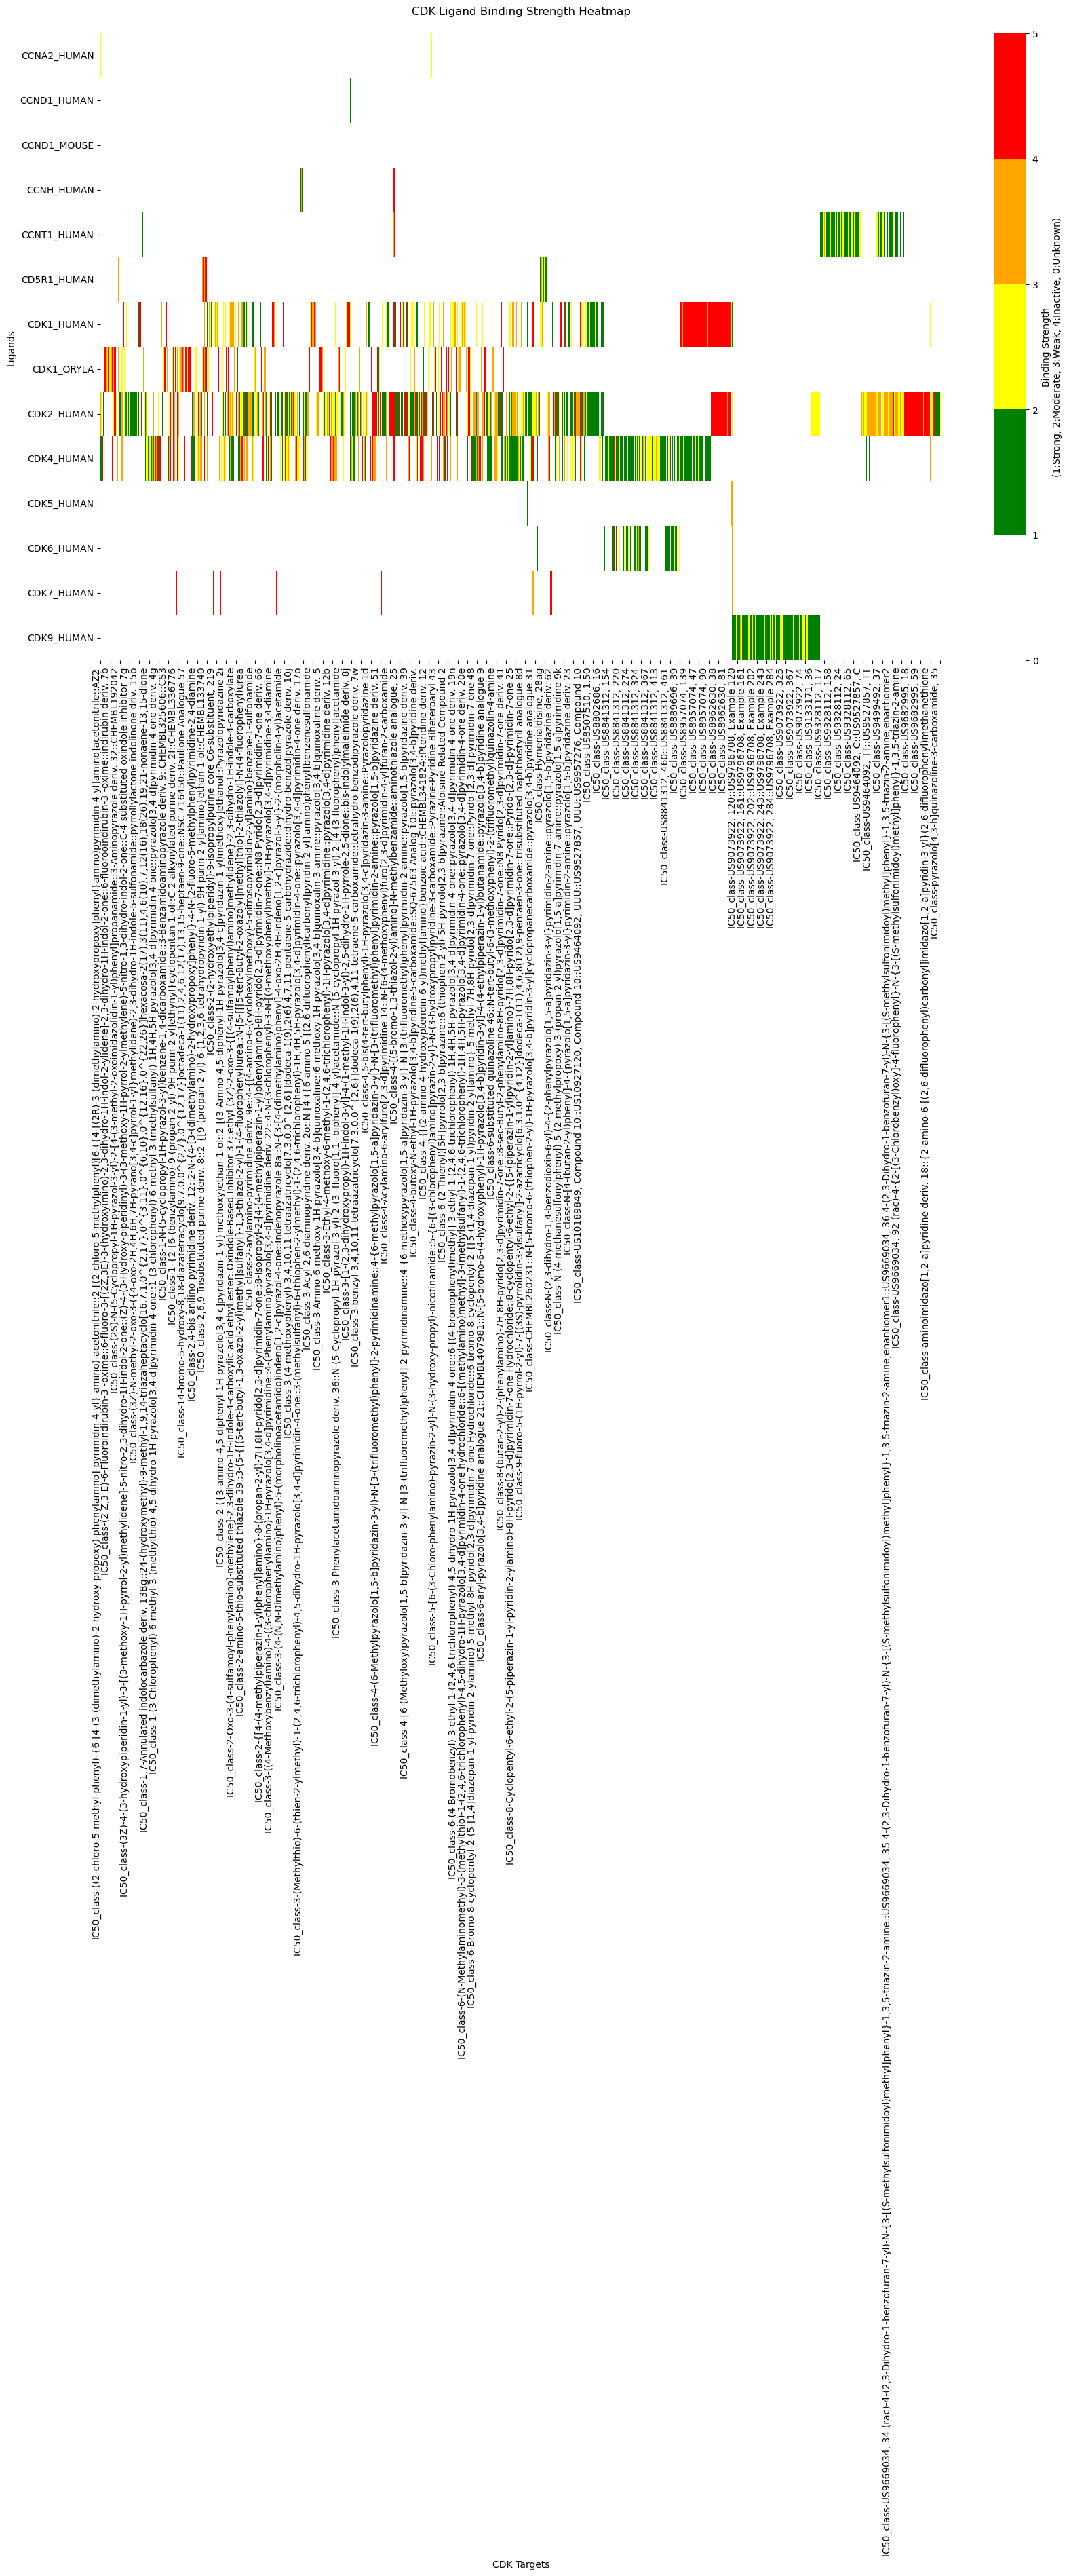

In [258]:
# Create heatmap
import matplotlib.colors as mcolors
plt.figure(figsize=(20, 12))


discrete_colormap = mcolors.ListedColormap(["white", "green", "yellow", "orange", "red"])

bounds = [0,1,2,3,4,5]
norm = mcolors.BoundaryNorm(bounds, discrete_colormap.N)

ax = sns.heatmap(
    IC50_pivot,
    cmap=discrete_colormap,
    norm=norm,
    annot=False,  # Too many values to annotate
    cbar_kws={
        "label": "Binding Strength\n(1:Strong, 2:Moderate, 3:Weak, 4:Inactive, 0:Unknown)",
        "orientation": "vertical",
        "ticks": [0, 1, 2, 3, 4, 5],  # Ensure the color bar has discrete labels
    },
)

plt.title("CDK-Ligand Binding Strength Heatmap", pad=20)
plt.xlabel("CDK Targets")
plt.ylabel("Ligands")

# Rotate x-axis labels for readability
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)


plt.show()

In [259]:
### Figuring if there are ligands that are strong across multiple CDK's 
### For each ligand counting the amount of times it is strong across CDK's

IC50_ligand_strong = IC50_df[IC50_df["IC50_class"] == "strong"]
IC50_ligand_strong.groupby("BindingDB Ligand Name")

In [260]:
IC50_ligand_strong.groupby("BindingDB Ligand Name")["IC50_class"].count().sort_values(ascending=False)

BindingDB Ligand Name
8-Cyclohexyl-2-[4-(4-methylpiperazin-1-yl)phenylamino]-8H-pyrido[2,3-d]pyrimidin-7-one::8-cyclohexyl-2-{[4-(4-methylpiperazin-1-yl)phenyl]amino}-7H,8H-pyrido[2,3-d]pyrimidin-7-one::N8 Pyrido[2,3-d]pyrimidin-7-one deriv. 70                                        4
3-[(9bR)-5-oxo-1H,2H,3H,5H,9bH-benzo[a]pyrrolizin-9-yl]-1-pyridin-2-ylurea::CHEMBL141247::N -(pyrrolidino[2,1-b]isoindolin-4-on-8-yl)-N-(pyridin-2yl)urea::Pyridin-2-yl urea::diarylurea deriv. 1                                                                     4
2-aminothiazole 6::5-{[(5-tert-butyl-1,3-oxazol-2-yl)methyl]sulfanyl}-N-phenyl-1,3-thiazol-2-amine                                                                                                                                                                    3
Pyrazolopyrimidone analog, RGB-286147                                                                                                                                                     

In [261]:
thiazol_2_amine_ligand_df = IC50_df[
    IC50_df["BindingDB Ligand Name"]
    == "2-aminothiazole 7::5-{[(5-tert-butyl-1,3-oxazol-2-yl)methyl]sulfanyl}-N-(pyridin-2-yl)-1,3-thiazol-2-amine"
]
thiazol_2_amine_ligand_df

,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM),IC50_class
1114,"2-aminothiazole 7::5-{[(5-tert-butyl-1,3-oxazo...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,2.0,strong
1115,"2-aminothiazole 7::5-{[(5-tert-butyl-1,3-oxazo...",Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,Homo sapiens,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN,9.0,strong
1116,"2-aminothiazole 7::5-{[(5-tert-butyl-1,3-oxazo...",Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,4.0,strong


In [262]:
US8507510_df = IC50_df[IC50_df["BindingDB Ligand Name"] == "US8507510, 1.18"]

In [263]:
US8507510_df.head()

,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM),IC50_class
3527,"US8507510, 1.18",Cyclin-dependent kinase 1,Homo sapiens,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,3.0,strong
3528,"US8507510, 1.18",Cyclin-dependent kinase 2,Homo sapiens,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,3.0,strong


In [264]:
IC50_CDK_strong = IC50_df[IC50_df["IC50_class"] == "strong"]
IC50_CDK_strong_grouped = IC50_CDK_strong.groupby("Target Name")["IC50_class"].count().sort_values(ascending=False)
IC50_CDK_strong_copy = IC50_CDK_strong.copy()

In [265]:
for row in thiazol_2_amine_ligand_df.iterrows():
    print(row[1]["Target Name"])
    print("BindingDB Target Chain Sequence")
    print(row[1]["BindingDB Target Chain Sequence"])

Cyclin-dependent kinase 2/G1/S-specific cyclin-E1
BindingDB Target Chain Sequence
MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1
BindingDB Target Chain Sequence
MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALLRRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDLMRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWYRAPEVLLQSTYATPVDMWSVGCIFAEMFRRKPLFCGNSEADQLGKIFDLIGLPPEDDWPRDVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHKRISAFRALQHSYLHKDEGNPE
Cyclin-dependent kinase/G2/mitotic-specific cyclin- 1
BindingDB Target Chain Sequence
MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPSTAIREISLLKELRHPNIVSLQDVLMQDSRLYLIFEFLSMDLKKYLDSIPPGQYMDSSLVKSYLYQILQGIVFCHSRRVLHRDLKPQNLLIDDKGTIKLADF

In [266]:
uniprot_of_cdks_df = df[["Target Name", "BindingDB Target Chain Sequence", "UniProt (SwissProt) Entry Name of Target Chain"]].drop_duplicates()

In [267]:
uniprot_of_cdks_df[
    uniprot_of_cdks_df["Target Name"].isin(
        [
            "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1",
            "Cyclin-dependent kinase 4/G1/S-specific cyclin-D1",
            "Cyclin-dependent kinase/G2/mitotic-specific cyclin- 1",
            "Cyclin-dependent kinase 1",
            "Cyclin-dependent kinase 2",
        ]
    )
]

,Target Name,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain
0,Cyclin-dependent kinase/G2/mitotic-specific cy...,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN
21,Cyclin-dependent kinase 2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN
22,Cyclin-dependent kinase 1,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN
336,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...,CDK4_HUMAN
345,Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN
1988,Cyclin-dependent kinase 4/G1/S-specific cyclin-D1,mehqllccevetirraypdtnllndrvlramlkteetcapsvsyfk...,CCND1_MOUSE


In [268]:
print(uniprot_of_cdks_df["UniProt (SwissProt) Entry Name of Target Chain"].unique())

['CDK1_HUMAN' 'CDK2_HUMAN' 'CDK1_ORYLA' 'CDK4_HUMAN' 'CCND1_HUMAN'
 'CCND1_MOUSE' 'CD5R1_HUMAN' 'CCNH_HUMAN' 'CCNT1_HUMAN' 'CCNA2_HUMAN'
 'CD11B_HUMAN' 'CD11A_HUMAN' 'CDK19_HUMAN' 'CDK7_HUMAN' 'CDK8_HUMAN'
 'CDK9_HUMAN' 'CDK3_HUMAN' 'CDK5_HUMAN' 'CDK16_HUMAN' 'CDK17_HUMAN'
 'CDK18_HUMAN' 'CDK14_HUMAN' 'CDK6_HUMAN' 'CCNE1_HUMAN' nan 'CDKL2_HUMAN']


In [269]:
## Looking into similarities between the 2 ligands that are strong on CDK 2 & 1

print(US8507510_df["BindingDB Ligand Name"].unique())
print(thiazol_2_amine_ligand_df["BindingDB Ligand Name"].unique())



['US8507510, 1.18']
['2-aminothiazole 7::5-{[(5-tert-butyl-1,3-oxazol-2-yl)methyl]sulfanyl}-N-(pyridin-2-yl)-1,3-thiazol-2-amine']


In [270]:
IC50_CDK_strong_grouped

Target Name
Cyclin-dependent kinase 4                                    329
Cyclin-dependent kinase 2/G1/S-specific cyclin-E1            323
Cyclin-dependent kinase 9                                    317
Cyclin-A2/Cyclin-dependent kinase 2                          200
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1            197
Cyclin-T1/Cyclin-dependent kinase 9                          195
Cyclin-dependent kinase 6                                    139
Cyclin-dependent kinase/G2/mitotic-specific cyclin- 1         88
Cyclin-dependent kinase 2                                     84
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1 [L188C]     83
Cyclin-dependent kinase 1                                     76
Cyclin-dependent kinase 1/G2/mitotic-specific cyclin-B        24
Cyclin-dependent kinase 5 activator 1                         15
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2                  7
Cyclin-H/Cyclin-dependent kinase 7                             6
Cyclin-depend

In [271]:
test = IC50_CDK_strong_copy[IC50_CDK_strong_copy["Target Name"] == "Cyclin-dependent kinase 4"]
test.shape


(329, 7)